In [0]:
import os
import pydot
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import xgboost as xgb
import matplotlib.pyplot as plt

In [0]:
def compute_f(X_trans, y, feature_names):
  F, p = f_regression(X_trans, y)
  F_test = pd.DataFrame(zip(feature_names, F, p), 
                    columns = ['feature', 'F-score', 'p-value']).sort_values('F-score', ascending = False)
  return F_test

def fit_model(X, y):
  categorical = X.dtypes == object
  ohe = OneHotEncoder(handle_unknown='ignore')

  X_trans = ohe.fit_transform(X).toarray()

  feature_names = pd.get_dummies(X).columns

  F_test = compute_f(X_trans, y, feature_names)
  
  baseline = LinearRegression(normalize=True)
  bst_linear = xgb.XGBRegressor(n_estimators=50, max_depth = 3, booster='gblinear')
  bst_dive = xgb.XGBRegressor(n_estimators=50, max_depth = 3)
  
  X_trans = pd.DataFrame(columns=feature_names, data=X_trans)

  baseline.fit(X_trans, y)
  bst_linear.fit(X_trans, y)
  bst_dive.fit(X_trans, y)
  # print(rg.score(X_trans, y))
  return X_trans, F_test, baseline, bst_linear, bst_dive

def plot_imp(store_name, model, feature_names, base=True, division='Total Sales', if_show=True):
  
  coef = model.coef_
  coef_idx = np.argsort(coef)[::-1]
  s = [feature_names[i] for i in coef_idx[:5]] + [feature_names[i] for i in coef_idx[-5:]]
  t = [coef[i] for i in coef_idx[:5]] + [coef[i] for i in coef_idx[-5:]]
  colors=['red'if c > 0 else 'blue' for c in t]

  plt.figure(figsize=(12, 10))
  plt.bar(s, t, color=colors)
  _ = plt.xlabel('Features')
  _ = plt.ylabel('Coefficients')
  if base:
    _ = plt.title('Coefficients for Baseline Linear Regression Model\n' +
                  division + '\n' +
                  store_name)
    filename = 'baseline_result.png'
  else:
    _ = plt.title('Features for XGB Regression Model\n' +
                  division + '\n' +
                  store_name)
    filename = 'xgb_result.png'

  _ = plt.xticks(rotation=90)
  plt.tight_layout()
  path = store_name + ' ' + division + ' Spot Events Model Analysis'
  plt.savefig(path + '/' + filename)
  if if_show:
    plt.show()

  return coef_idx

def spot_events_analysis(store_name, events, sales, FROM=0, TO=100, is_annual=False, division='Total Sales', if_show=True):

  events_filtered = pd.DataFrame([events.iloc[i] for i in range(len(events)) 
    if events['category'].values[i] not in ['severe-weather', 'observances', 
                                            'airport-delays', 'academic', 
                                            'school-holidays', 'public-holidays']])
  
  events_sorted = events_filtered.sort_values(by=['impact_linear'], ascending=False)

  top_events = events_sorted.iloc[FROM:TO]

  df = pd.merge(top_events, sales, on='date')

  df = df[['title', 'sales_cleaned']].dropna()

  X = df[['title']]
  y = df['sales_cleaned']

  path = store_name + ' ' + division + ' Spot Events Model Analysis'
  if not os.path.exists(path):
    os.mkdir(path)

  # model fitting
  X_trans, F_test, baseline, bst_linear, bst_dive = fit_model(X, y)
  
  # Feature Screening
  if if_show:
    print(F_test[F_test['p-value'] <= 0.1])
  F_test.to_csv(os.path.join(path, 'F_test.csv'))

  # Model Analysis
  plot_imp(store_name, baseline, X_trans.columns, division, if_show=if_show)
  idx = plot_imp(store_name, bst_linear, X_trans.columns, base=False, division=division, if_show=if_show)

  xgb.plot_importance(bst_dive, max_num_features=5)
  plt.savefig(path + '/XGB_Top_5_Feature_Importances.png')

  # Return positive5/bottom5 events
  tmp = X_trans.columns[idx[:5]]
  pos_5 = [tmp[i].split('_')[1] for i in range(5)]
  pos = pd.DataFrame([events.iloc[i] for i in range(len(events)) if events['title'].values[i] in pos_5])
  pos.to_csv(path + '/top5_positive_events.csv')

  tmp = X_trans.columns[idx[-5:]]
  neg_5 = [tmp[i].split('_')[1] for i in range(5)]
  neg = pd.DataFrame([events.iloc[i] for i in range(len(events)) if events['title'].values[i] in neg_5])
  neg.to_csv(path + '/bottom5_negative_events.csv')

def spot_events_divisions_analysis(store_name, events, divisions, FROM=0, TO=100, is_annual=False):
  
  men = divisions['men']
  women = divisions['women']
  acc = divisions['accessory']

  spot_events_analysis(store_name, events, men, FROM, TO, is_annual, 'Men Sales', if_show=False)
  spot_events_analysis(store_name, events, women, FROM, TO, is_annual, 'Women Sales', if_show=False)
  spot_events_analysis(store_name, events, acc, FROM, TO, is_annual, 'Accessory Sales', if_show=False)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Sample Data Preperation
events = pd.read_csv("/content/drive/My Drive/Events cleaned data/events_ORLANDO FOA.csv")
sales = pd.read_csv("/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_men_cleaned.csv")
men = pd.read_csv('/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_men_cleaned.csv')
women = pd.read_csv('/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_women_cleaned.csv')
acc = pd.read_csv('/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_accessory_cleaned.csv')

events.date = pd.to_datetime(events.date, format='%Y-%m-%d')
sales.date = pd.to_datetime(sales.date, format='%Y-%m-%d')
men.date = pd.to_datetime(men.date, format='%Y-%m-%d')
women.date = pd.to_datetime(women.date, format='%Y-%m-%d')
acc.date = pd.to_datetime(acc.date, format='%Y-%m-%d')

divisions = {
    'men': men,
    'women': women,
    'accessory': acc
}

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                                              feature   F-score   p-value
19                   title_ORLANDO BUSINESS EXPANSION  7.887012  0.006010
17           title_Motor Drive and Automation Systems  6.280712  0.013853
0   title_"Road to Action" Spring Regional Meeting...  4.417497  0.038137
20  title_ORLANDO INTERNATIONAL KIZOMBA FESTIVAL 2018  3.078004  0.082484


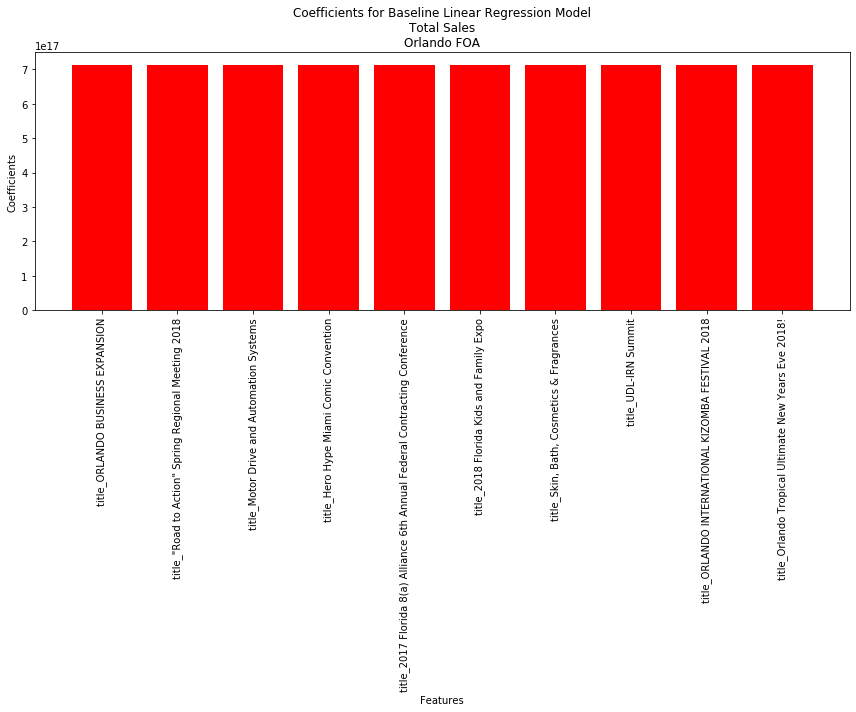

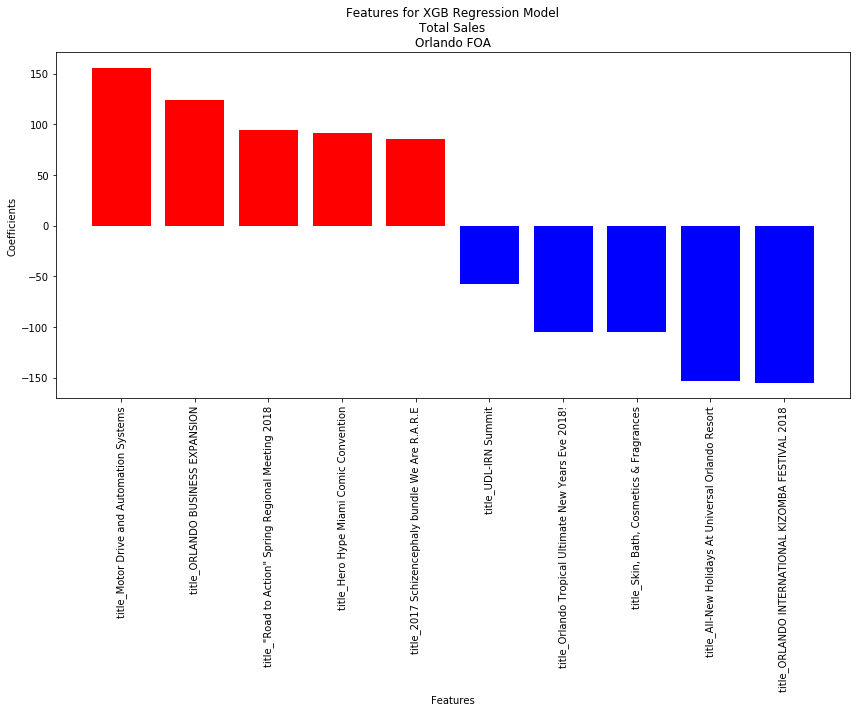

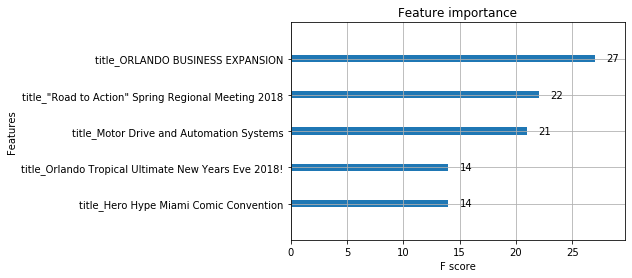

In [23]:
spot_events_analysis('Orlando FOA', events, sales)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:23:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:23:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


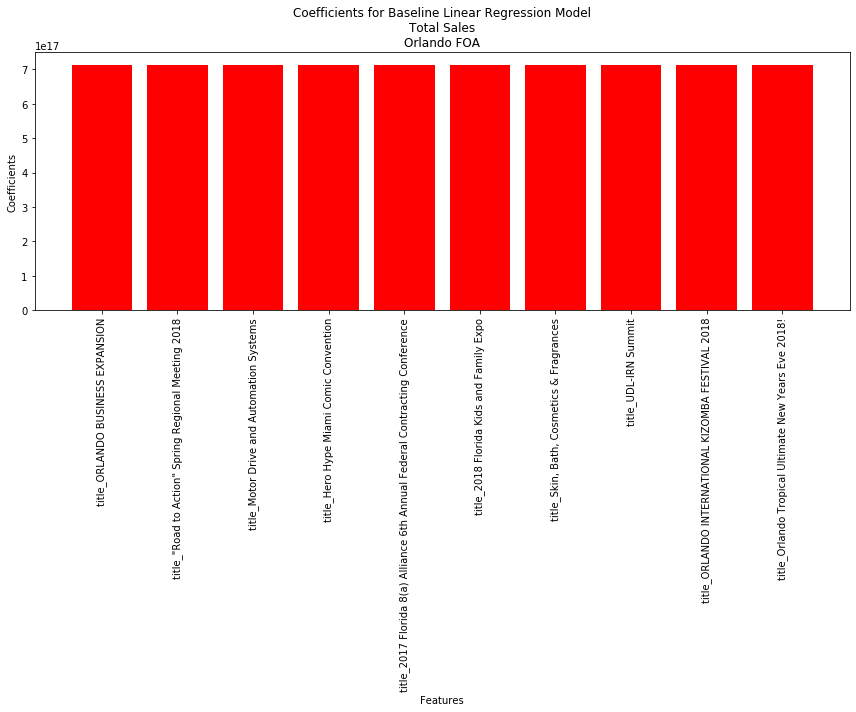

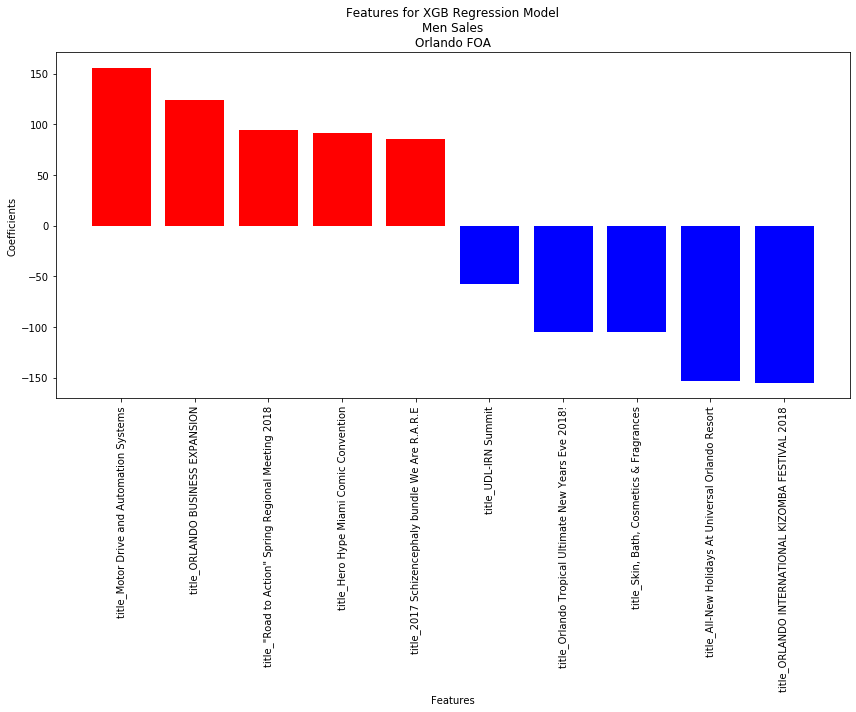

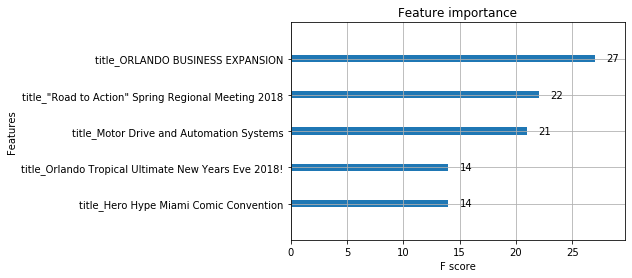

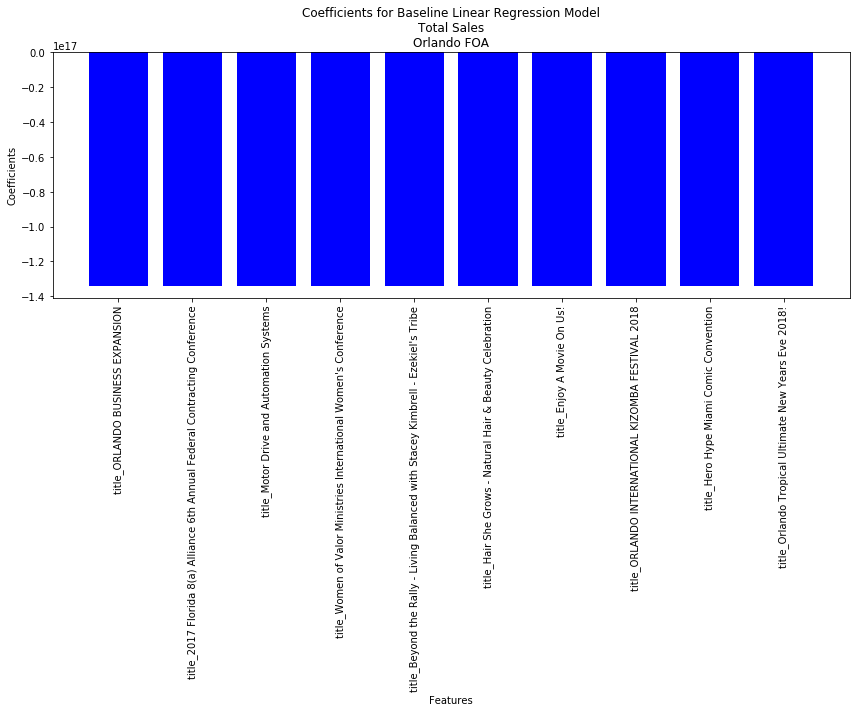

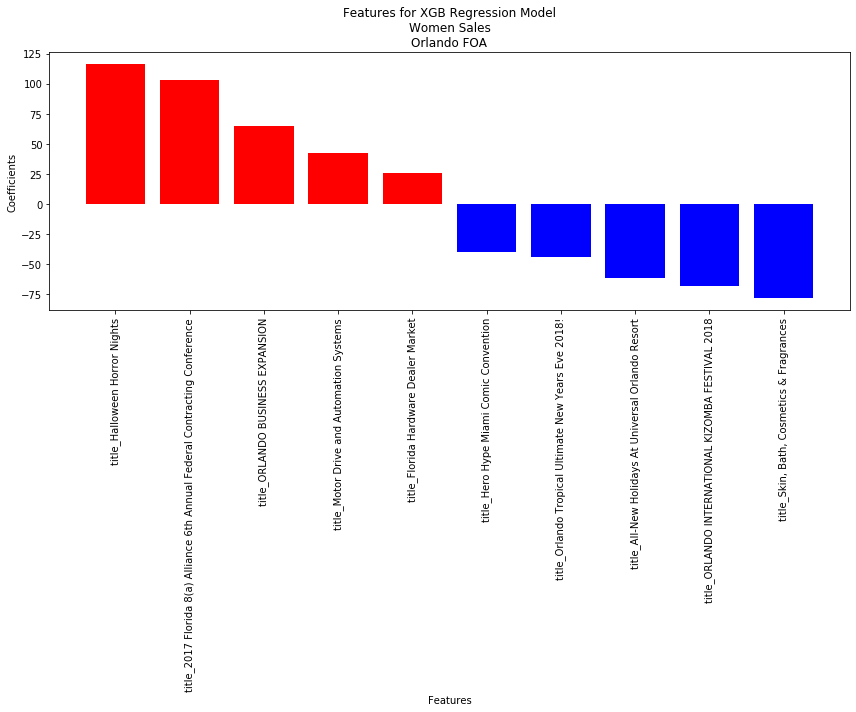

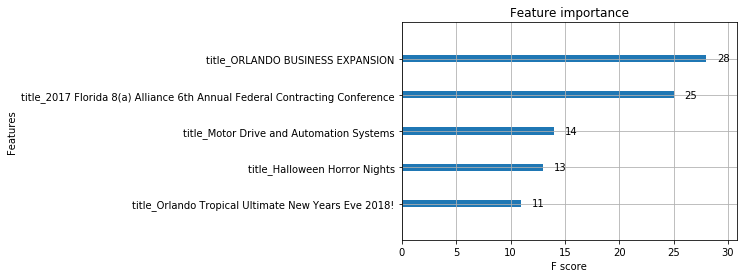

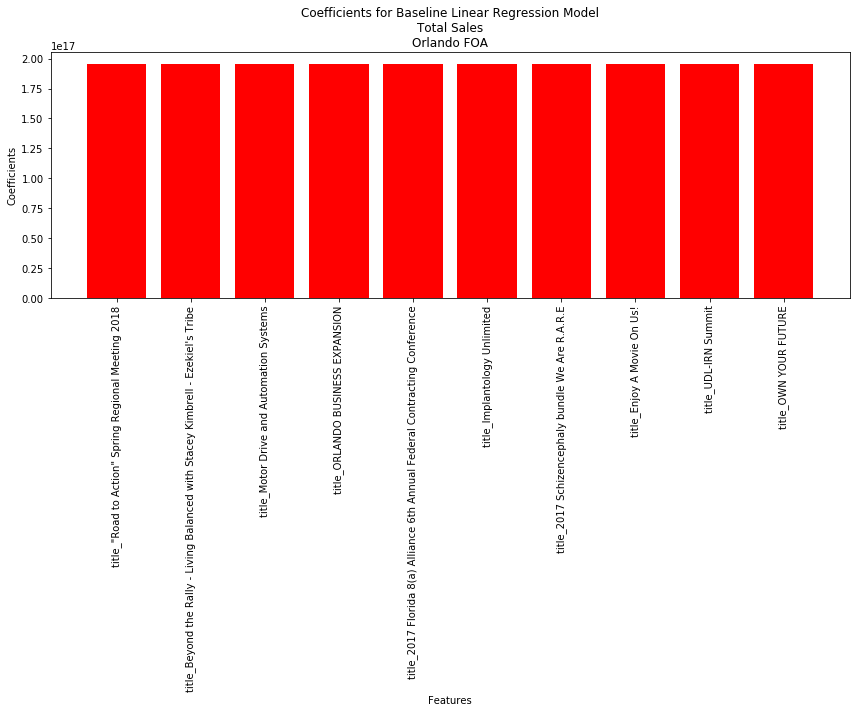

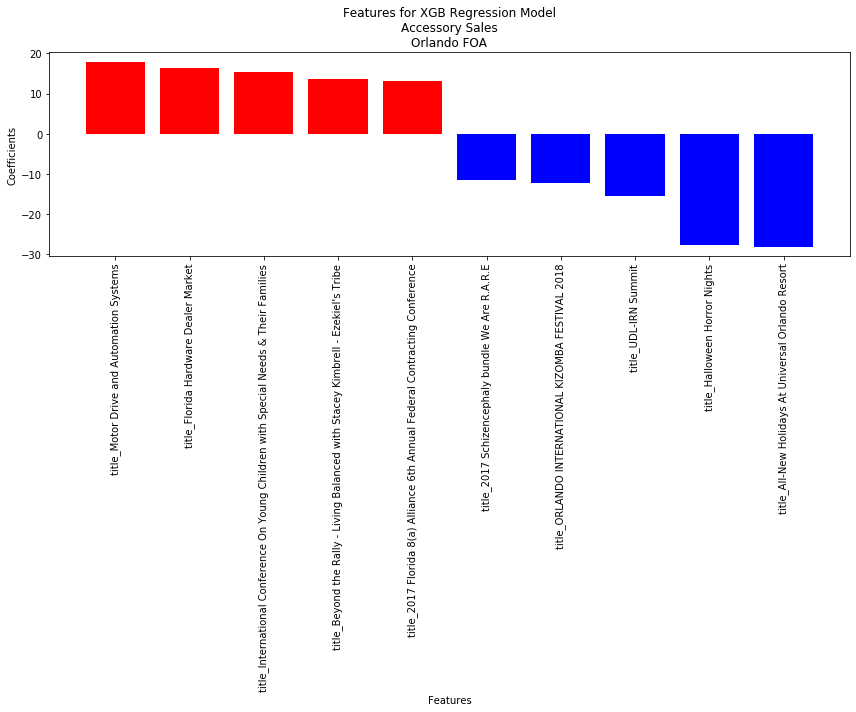

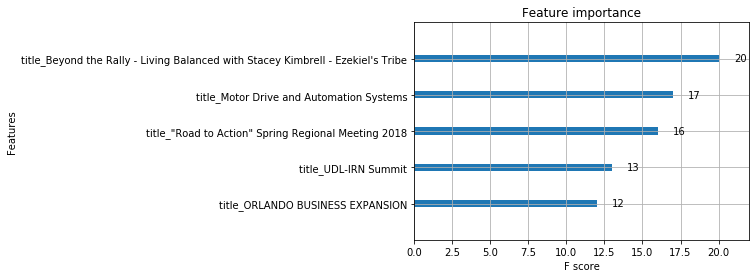

In [24]:
spot_events_divisions_analysis('Orlando FOA', events, divisions)